In [29]:
import numpy as np 
import pandas as pd

df = pd.read_csv(
    ".././data/COVID-19_aantallen_gemeente_per_dag.csv",
    sep=";",
)

In [63]:
def plot_data(df: pd.DataFrame, Municipality_name: str):
    df = df.copy(deep=True)
    df = df[df["Province"].notna()]
    df = df[df['Municipality_name'] == Municipality_name]
    df['total'] = df['Total_reported'].cumsum()
    df.plot(x='Date_of_publication', y='total', kind='line', figsize=(10,10))


### Prediction on individual city based on richard growth function


Optimal Parameters: F=311242.56070940214, IR=0.03676701317620005, L=121.32376412879917, C=0.7296859059934081
Mean Absolute Error on Test Data: 11185.709690544849


C:\Users\Ultis\AppData\Local\Temp\ipykernel_20988\2064171450.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total'] = df_filtered['Total_reported'].cumsum()
C:\Users\Ultis\AppData\Local\Temp\ipykernel_20988\2064171450.py:34: RuntimeWarning: invalid value encountered in power
  denominator = (1 + C * expo) ** (1 / C)


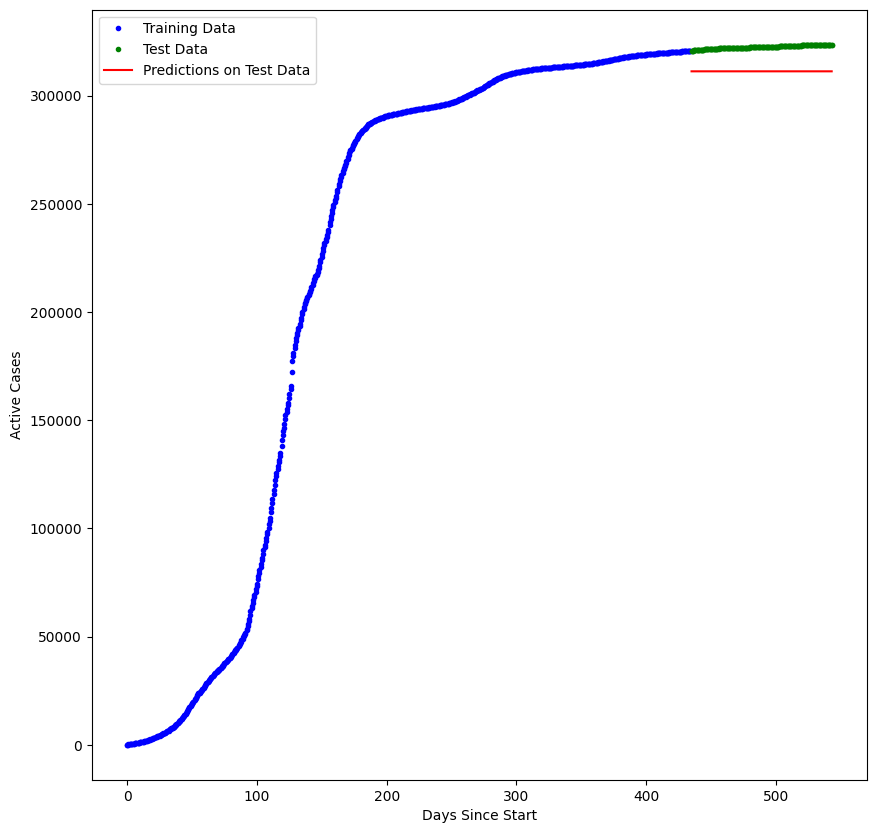

In [77]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error

# Filter country by city
def filter_country(df: pd.DataFrame, Municipality_name): 
    df = df.copy(deep=True)
    df_filtered = df[df["Province"].notna() & (df["Municipality_name"] == Municipality_name)]
    df_filtered['total'] = df_filtered['Total_reported'].cumsum()
    return df_filtered

city_1 = filter_country(df, "Amsterdam") # input desired city available in city_list 

X = pd.to_datetime(city_1["Date_of_publication"])  
X = (X - X.min()).dt.days.values.astype(float)  
y = city_1['total'].values  

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# The Richards (generalized logistic) growth function 
def RG_logistic_growth(t, F, IR, L, C): 
    """
    t -> time, day since start 
    F -> final epidemic size 
    IR -> infection rate 
    L -> lag phase 
    C -> carrying capacity
    
    """
    numerator = F
    expo = np.exp(-IR * (t - L))
    denominator = (1 + C * expo) ** (1 / C)
    return numerator / denominator

initial_guess = [max(y_train), 0.1, np.average(X_train), 1]

optp, covp = curve_fit(RG_logistic_growth, X_train, y_train, p0=initial_guess)

F_opt, IR_opt, L_opt, C_opt = optp
print(f"Optimal Parameters: F={F_opt}, IR={IR_opt}, L={L_opt}, C={C_opt}")

y_pred = RG_logistic_growth(X_test, F_opt, IR_opt, L_opt, C_opt)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Data: {mae}")

plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, 'b.', label='Training Data')
plt.plot(X_test, y_test, 'g.', label='Test Data')
plt.plot(X_test, y_pred, 'r-', label='Predictions on Test Data')
plt.xlabel('Days Since Start')
plt.ylabel('Active Cases')
plt.legend()
plt.show()


### Nature article -> covid-19 spread 
https://www.nature.com/articles/s41598-023-31714-5